### Building Chatbot with Multiple Tools using LangGraph

#### Aim
Create a chatbot with tool capabilities from arxiv, wikipedia search and some functions

In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [4]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [5]:
arxiv.invoke("Attention is all you need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [6]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [8]:
wiki.invoke("What is machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [9]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [10]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily=TavilySearchResults()

C:\Users\Anay Mishra\AppData\Local\Temp\ipykernel_28732\3543858584.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily=TavilySearchResults()


In [11]:
tavily.invoke("Provide me th recent AI news")

[{'title': 'AI News | Latest News | Insights Powering AI-Driven Business ...',
  'url': 'https://www.artificialintelligence-news.com/',
  'content': '### Zara’s use of AI shows how retail workflows are quietly changing\n\nDeep Dives\n\nDecember 19, 2025\n\n### Roblox brings AI into the Studio to speed up game creation\n\nAI in Action\n\nDecember 17, 2025\n\n#### Industries\n\n### Disney is embedding generative AI into its operating model\n\nEntertainment & Media\n\nDecember 24, 2025\n\n### Arm and the future of AI at the edge\n\nAI Hardware & Chips\n\nDecember 23, 2025\n\n### Marketing agencies using AI in workflows serve more clients\n\nMarketing AI [...] ### AI & Big Data Expo Global 2026\n\n4 February 2026 9:00 am\n\nto\n\n5 February 2026 4:00 pm\n\nOlympia, London\n\n|\n\nLondon\n\n## Related News\n\nAI News\n\nDecember 24, 2025\n\n## Disney is embedding generative AI into its operating model\n\nAI News\n\nDecember 24, 2025\n\n## The future of rail: Watching, predicting, and learni

In [12]:
## Combine all the tools in the list

tools=[arxiv,wiki,tavily]

In [13]:
## Initialize my LLM Model
from langchain_groq import ChatGroq
llm=ChatGroq(model="openai/gpt-oss-20b")
llm_with_tools=llm.bind_tools(tools)

In [15]:
from pprint import pprint
from langchain_core.messages import AIMessage,HumanMessage

llm_with_tools.invoke([HumanMessage(content=f"What is recent AI news")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': 'fc_57040ec9-745d-4252-82c4-d4e8eb24126c',
  'type': 'tool_call'}]

In [16]:
## State schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

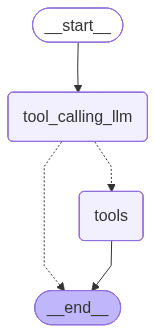

In [17]:
### Entire Chatbot with LangGraph
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return{"messages":[llm_with_tools.invoke(state["messages"])]}

## Build graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools",END)

graph=builder.compile()

#View
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
messages=graph.invoke({"messages":HumanMessage(content="What is attention is all you need search using arxiv tool")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is attention is all you need search using arxiv tool
================================== Ai Message ==================================
Tool Calls:
  arxiv (fc_2bdf08e7-5df7-416d-b132-636bb5f49fac)
 Call ID: fc_2bdf08e7-5df7-416d-b132-636bb5f49fac
  Args:
    query: Attention is All You Need
================================= Tool Message =================================
Name: arxiv

Published: 2021-05-06
Title: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet
Authors: Luke Melas-Kyriazi
Summary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi


In [20]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news for March 3rd 2025")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news for March 3rd 2025
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (fc_5019e648-a1ad-4097-a5d4-614ff6ec0320)
 Call ID: fc_5019e648-a1ad-4097-a5d4-614ff6ec0320
  Args:
    query: March 3 2025 AI news top 10
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI News: Top 10 Developments Business Leaders Need to Know ...", "url": "https://www.linkedin.com/posts/russellsarder_ai-ainews-aicerts-activity-7302070199288025090-DCHY", "content": "AI News: Top 10 Developments Business Leaders Need to Know By Russell Sarder | March 3, 2025 The AI industry saw a wave of major announcements this past week. Here are the 10 most important AI updates from the past week. 1) OpenAI Releases GPT-4.5 'Orion' – OpenAI introduced its latest AI 

In [21]:
messages=graph.invoke({"messages":HumanMessage(content="What is machine learning")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================

**Machine learning (ML)** is a branch of computer science and artificial intelligence that focuses on developing algorithms and statistical models that enable computers to perform specific tasks without explicit instructions. Instead of being programmed with hard‑coded rules, ML systems learn from data:

1. **Data ingestion** – Collect and preprocess large amounts of relevant information (images, text, sensor readings, etc.).
2. **Model training** – Use mathematical techniques (e.g., regression, neural networks, decision trees) to find patterns or relationships in the data.
3. **Evaluation** – Measure how well the model predicts or classifies new, unseen data.
4. **Deployment** – Integrate the trained model into applications so it can make real‑time decisions or predictions.

Key characteristics:
- *